
## In this nodebook, I will implement a time-seris model arima-lstm hybrid to predict the stock of Google company based on other stocks, ETFs, financial indicies and technical indicators.





# **1. Load dependencies and data**

## Load dependencies

In [64]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for time-series analysis
from statsmodels.tsa.arima_model import ARIMA

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import spearmanr
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## Load Data And Preprocessing

In [65]:
Apple_data = pd.read_csv('AAPL.csv')
Amd_data = pd.read_csv('AMD.csv')
Amazon_data = pd.read_csv('AMZN.csv')
Dia_data = pd.read_csv('DIA.csv')
Gbpusd_data = pd.read_csv('GBPUSD=X.csv')
Google_data = pd.read_csv('GOOG.csv')
Ibm_data = pd.read_csv('IBM.csv')
Jpy_data = pd.read_csv('JPY=X.csv')
Microsoft_data = pd.read_csv('MSFT.csv')
Nvidia_data = pd.read_csv('NVDA.csv')
Qqq_data = pd.read_csv('QQQ.csv')
Spy_data = pd.read_csv('SPY.csv')
Vix_data = pd.read_csv('VIX.csv')


In [66]:
# this is the function to clean the data
def clean_data(df):
    cleaned_df = pd.DataFrame()
    cleaned_df["Date"] = pd.to_datetime(df.iloc[:, 0])
    cleaned_df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(str).astype(float)
    return cleaned_df
df_list = [Apple_data, Amd_data, Amazon_data, Dia_data, Gbpusd_data, Google_data,
        Ibm_data, Jpy_data, Microsoft_data, Nvidia_data, Qqq_data, Spy_data, Vix_data]
# Clean the data
for stock in df_list:
    df = pd.DataFrame()
    df = clean_data(stock)
    stock = df


In [67]:
stk_tickers = ['GOOG', 'AAPL', 'AMD', 'AMZN', 'MSFT', 'NVDA', 'IBM', ]
etf_tickers = ['SPY', 'QQQ']
ccy_tickers = ['GBPUSD=X', 'JPY=X']
idx_tickers = ['DIA', 'VIX']


stk_list = [Google_data,Apple_data, Amd_data, Amazon_data, Nvidia_data, Ibm_data]
etf_list = [Spy_data, Qqq_data]
ccy_list = [Gbpusd_data, Jpy_data]
idx_list = [Dia_data, Vix_data]
stk_data = pd.concat(stk_list,axis=1,keys=stk_tickers).swaplevel(0,1,axis=1).sort_index(axis=1)
etf_data = pd.concat(etf_list,axis=1,keys=etf_tickers).swaplevel(0,1,axis=1).sort_index(axis=1)
ccy_data = pd.concat(ccy_list,axis=1,keys=ccy_tickers).swaplevel(0,1,axis=1).sort_index(axis=1)
idx_data = pd.concat(idx_list,axis=1,keys=idx_tickers).swaplevel(0,1,axis=1).sort_index(axis=1)

print(stk_data)

       Adj Close                                                              \
            AAPL         AMD        AMZN        GOOG        MSFT        NVDA   
0       0.960588   21.410000    2.226000    5.048826    1.802891   54.325985   
1       0.970452   20.209999    2.107000    4.844342    1.718021   53.742443   
2       0.978952   19.750000    2.088500    4.819685    1.734078   53.631298   
3       0.979711   19.719999    2.052500    4.696148    1.717257   53.464561   
4       1.051045   19.920000    2.116000    4.828153    1.684379   53.231136   
...          ...         ...         ...         ...         ...         ...   
4672  193.220001  111.099998  128.250000  129.869995  459.000000  142.970001   
4673  195.830002  112.959999  132.210007  133.009995  467.500000  143.449997   
4674  196.449997  114.400002  133.679993  133.110001  467.290009  144.179993   
4675  195.610001  117.599998  131.690002  131.889999  465.070007  143.330002   
4676  192.580002  109.349998  128.210007

we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.
Next, we need to calculatet the return prrice for all other data

In [68]:
return_period = 5
Y = np.log(stk_data.loc[:, ('Adj Close', 'GOOG')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'
X1 = np.log(stk_data.loc[:, ('Adj Close', ('AAPL', 'AMD', 'AMZN', 'MSFT', 'NVDA', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(etf_data.loc[:, ('Adj Close', ('SPY', 'QQQ'))]).diff(return_period)
X2.columns = X2.columns.droplevel()
X3 = np.log(ccy_data.loc[:, ('Adj Close', ('GBPUSD=X', 'JPY=X'))]).diff(return_period)
X3.columns = X3.columns.droplevel()
X4 = np.log(idx_data.loc[:, ('Adj Close', ('DIA', 'VIX'))]).diff(return_period)
X4.columns = X4.columns.droplevel()
X5 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'GOOG')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X5.columns = ['GOOG_DT', 'GOOG_3DT', 'GOOG_6DT', 'GOOG_12DT']
X = pd.concat([X1, X2, X3, X4, X5], axis=1)
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]
print(Y, X)

60      0.070834
66     -0.037400
71      0.154043
76      0.019229
81      0.035806
          ...   
4650    0.012268
4655   -0.023924
4660    0.052703
4665   -0.010451
4671   -0.007898
Name: GOOG_pred, Length: 853, dtype: float64           AAPL       AMD      AMZN      MSFT      NVDA       SPY       QQQ  \
60   -0.020898  0.029590  0.032323 -0.054067  0.009456  0.008172  0.008514   
66    0.067377  0.054100  0.017199 -0.003405 -0.031906  0.004843  0.012081   
71   -0.212964 -0.100884 -0.046740 -0.093819 -0.132879 -0.033171 -0.053249   
76    0.004234 -0.056587  0.000606  0.040841 -0.033003  0.012363  0.010024   
81    0.015652 -0.025669 -0.020796 -0.014037  0.028822  0.001556 -0.003140   
...        ...       ...       ...       ...       ...       ...       ...   
4650  0.001891 -0.110574  0.014556 -0.049456 -0.045689 -0.018418 -0.026883   
4655  0.038074  0.074453  0.022443  0.042899  0.017585  0.028223  0.034648   
4660 -0.023021 -0.039628 -0.011120 -0.000189  0.005744 -0.003001 -

<ipython-input-68-0699e1183263>:4: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  X1 = np.log(stk_data.loc[:, ('Adj Close', ('AAPL', 'AMD', 'AMZN', 'MSFT', 'NVDA', 'IBM'))]).diff(return_period)


# 2. Exploratory Data Analysis

## 2.1 Descriptive Statistics

In [69]:
dataset.describe()


,GOOG_pred,AAPL,AMD,AMZN,MSFT,NVDA,SPY,QQQ,GBPUSD=X,JPY=X,DIA,VIX,GOOG_DT,GOOG_3DT,GOOG_6DT,GOOG_12DT
count,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000
mean,0.003759,0.005628,0.001871,0.005718,0.006540,0.001482,0.002319,0.003190,-0.000393,0.000289,0.002135,0.001584,0.004310,0.011910,0.022519,0.045104
std,0.039793,0.044491,0.081183,0.053638,0.067444,0.031430,0.024772,0.028427,0.013447,0.013608,0.023652,0.148859,0.040804,0.069223,0.097297,0.137623
min,-0.184272,-0.213110,-0.377560,-0.272333,-0.309436,-0.160265,-0.189256,-0.175386,-0.094236,-0.075373,-0.167891,-0.495296,-0.184272,-0.326255,-0.327663,-0.590719
25%,-0.017802,-0.020482,-0.042260,-0.019937,-0.028771,-0.013654,-0.007955,-0.011265,-0.008008,-0.006783,-0.007924,-0.082238,-0.017862,-0.028446,-0.038179,-0.036494
50%,0.005044,0.008612,0.002706,0.006501,0.009184,0.002092,0.004506,0.005144,0.000091,0.000139,0.003988,-0.008487,0.006589,0.015146,0.024313,0.050957
75%,0.025348,0.032199,0.049209,0.029465,0.044077,0.018756,0.014802,0.019025,0.007677,0.007968,0.013808,0.077778,0.026960,0.052428,0.082811,0.135489
max,0.174538,0.166015,0.390539,0.331215,0.318561,0.128781,0.177339,0.130397,0.054518,0.058130,0.153737,0.716867,0.174538,0.271733,0.363140,0.499923


In [70]:
dataset.head()

,GOOG_pred,AAPL,AMD,AMZN,MSFT,NVDA,SPY,QQQ,GBPUSD=X,JPY=X,DIA,VIX,GOOG_DT,GOOG_3DT,GOOG_6DT,GOOG_12DT
60,0.070834,-0.020898,0.029590,0.032323,-0.054067,0.009456,0.008172,0.008514,-0.015782,0.019111,0.005540,0.010234,0.008512,-0.004643,-0.078392,-0.115990
66,-0.037400,0.067377,0.054100,0.017199,-0.003405,-0.031906,0.004843,0.012081,0.002290,0.008720,0.004698,-0.057524,0.064577,0.068751,0.016591,-0.007728
71,0.154043,-0.212964,-0.100884,-0.046740,-0.093819,-0.132879,-0.033171,-0.053249,0.005996,-0.004350,-0.036702,-0.191132,-0.037400,0.031574,-0.010806,-0.064370
76,0.019229,0.004234,-0.056587,0.000606,0.040841,-0.033003,0.012363,0.010024,0.013653,-0.008758,0.011160,0.280577,0.154043,0.181219,0.181553,0.131382
81,0.035806,0.015652,-0.025669,-0.020796,-0.014037,0.028822,0.001556,-0.003140,-0.006021,-0.006949,0.000490,-0.003348,0.019229,0.135872,0.204623,0.065946


## 2.2 Data Visualization

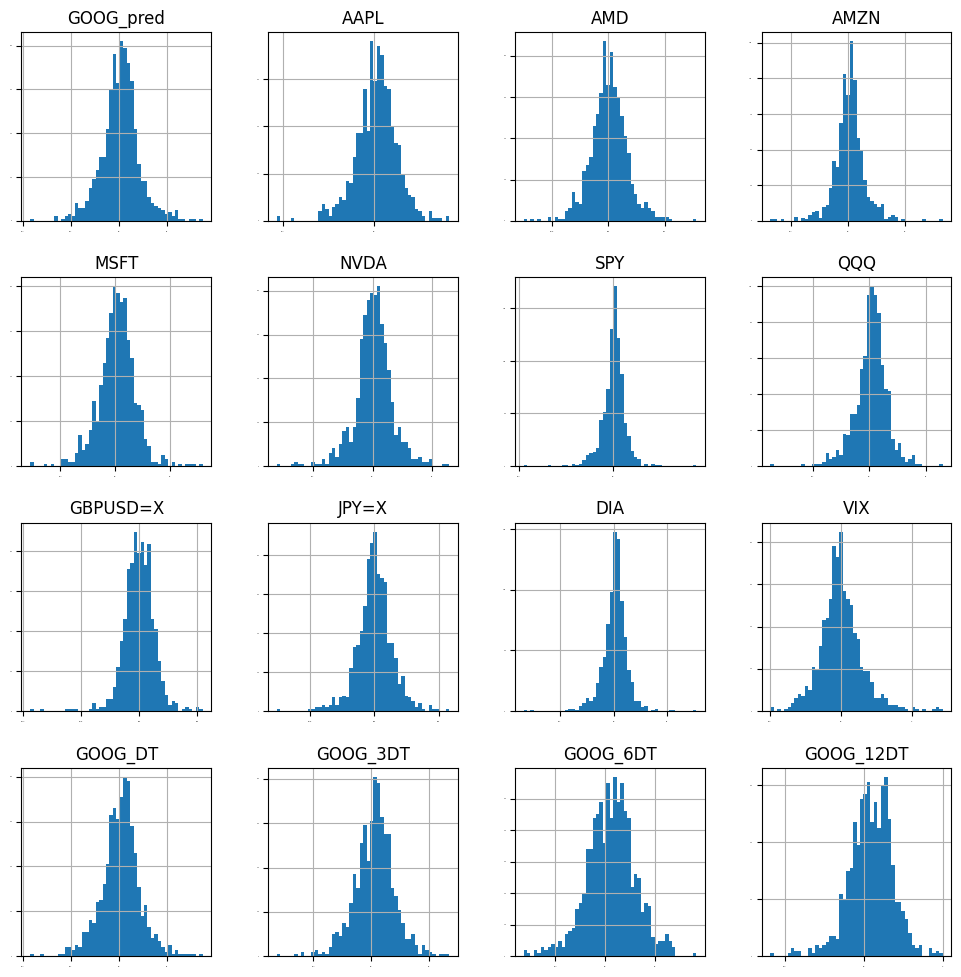

In [71]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

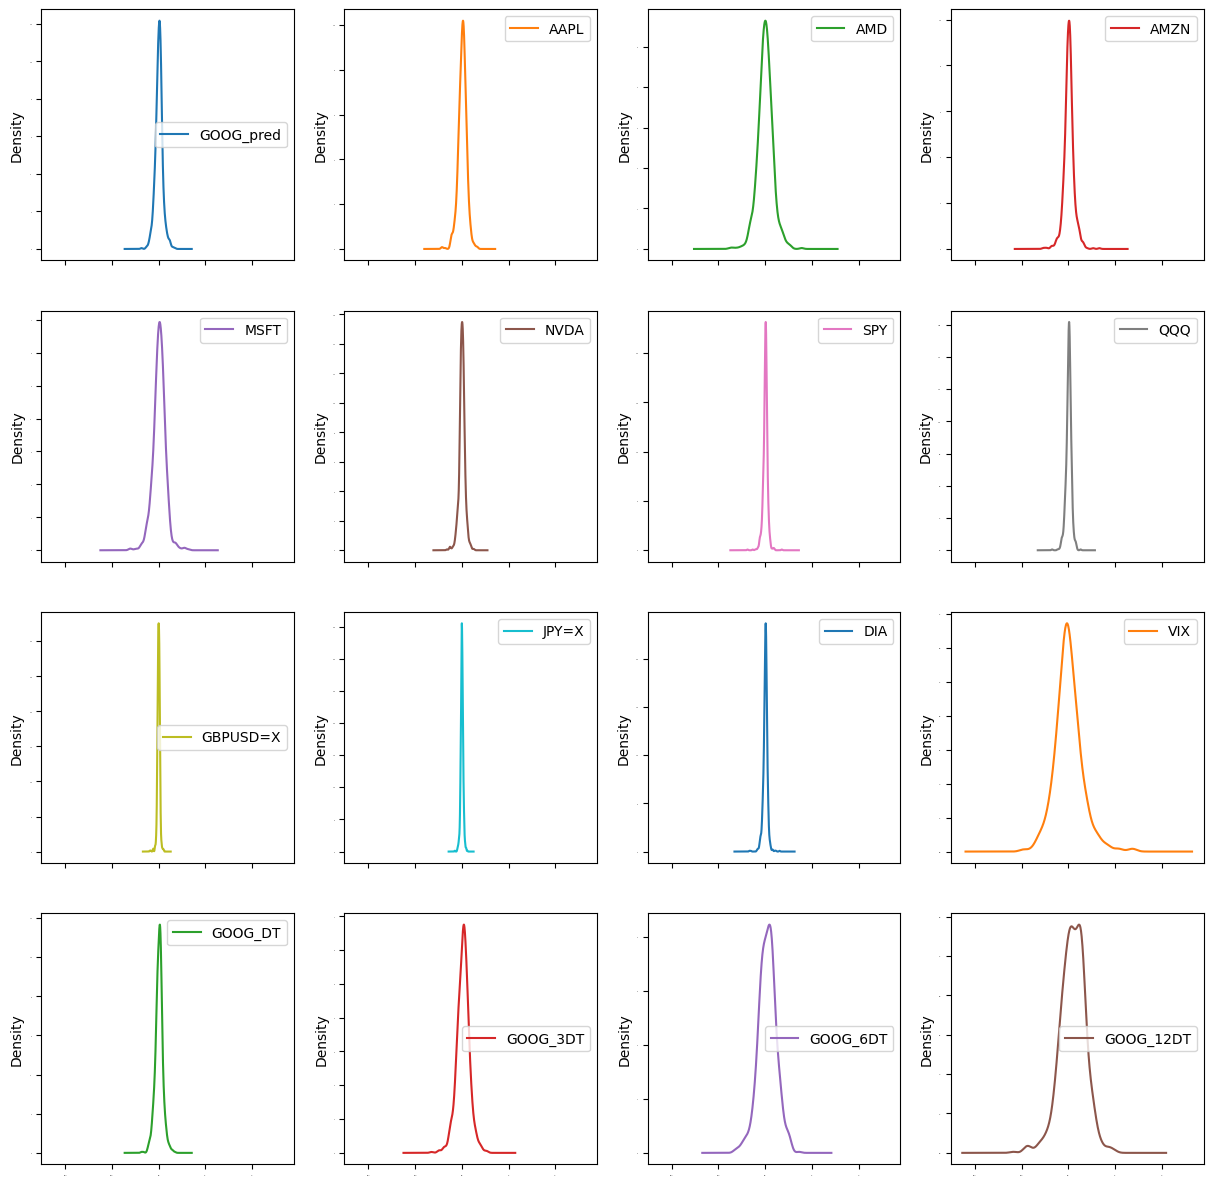

In [72]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

<Axes: title={'center': 'Correlation Matrix'}>

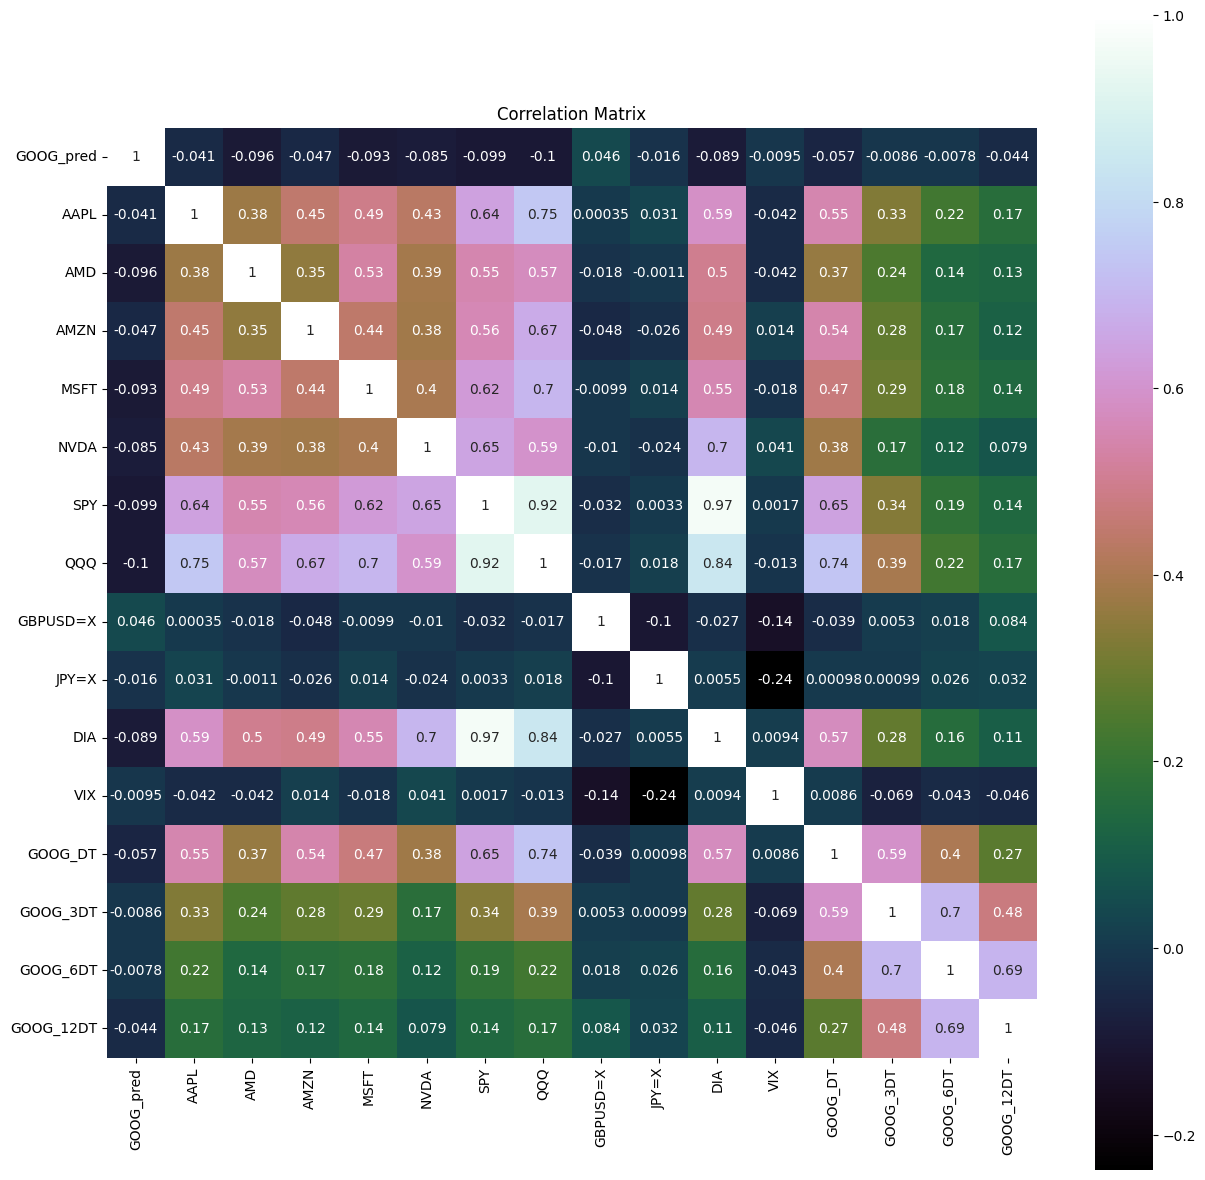

In [73]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

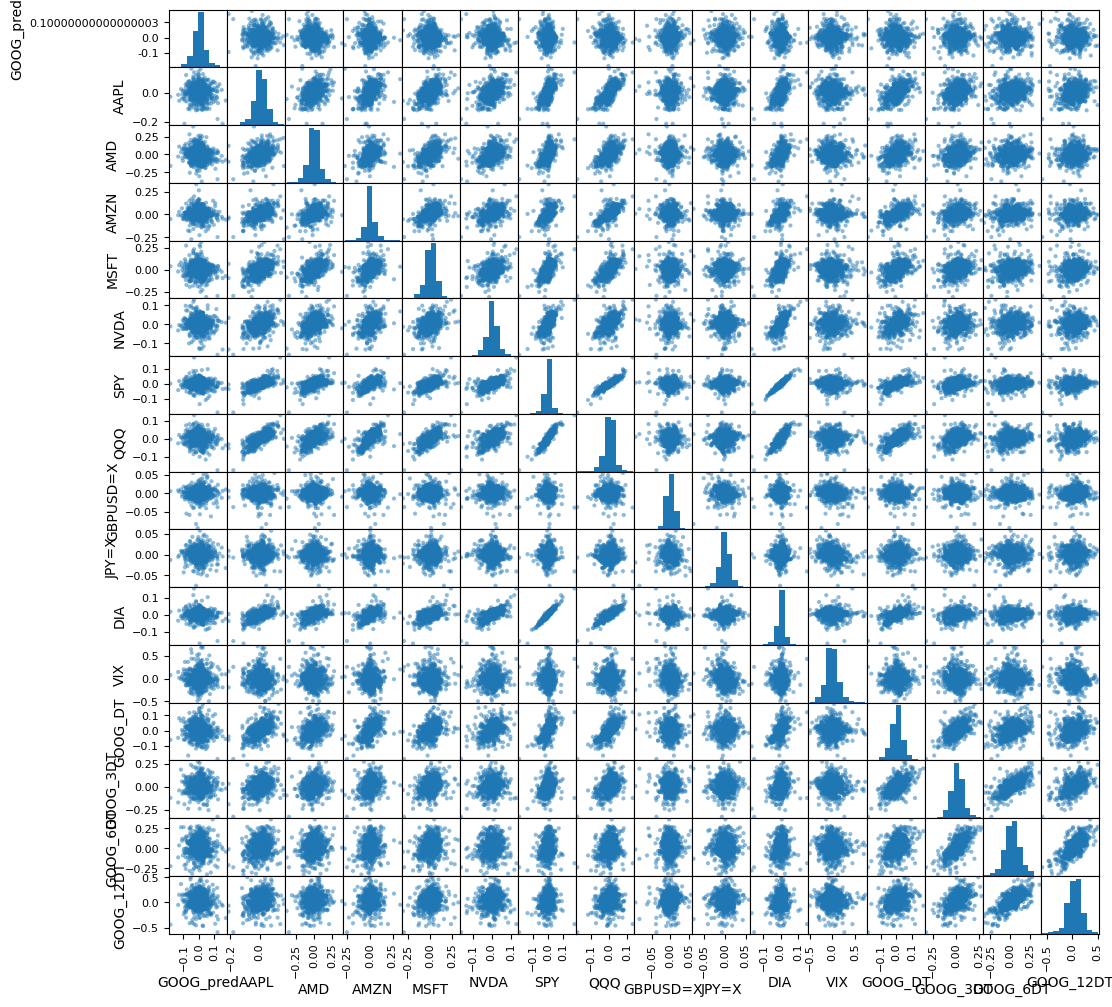

In [74]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

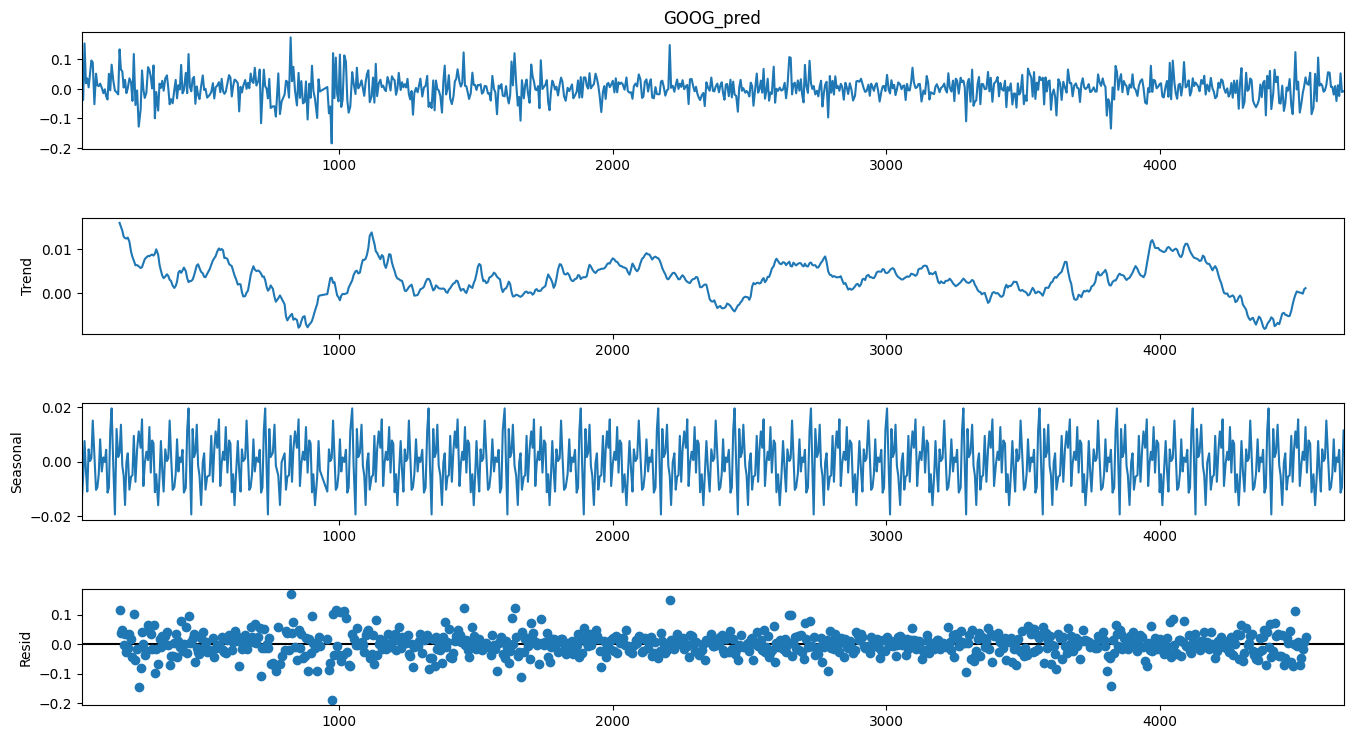

In [75]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()